In [1]:
# IMPORT PACKAGES
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import os
from sklearn import linear_model as lm, metrics, ensemble as ens
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier, XGBRegressor
import warnings

2024-04-08 11:09:32.405260: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# PULL IN SAVED CSV FROM HP-TUNING NOTEBOOK TO SAVE TIME
df = pd.read_csv("full_info.csv")
df['state'] = df['state'].apply(lambda x: re.sub('District Of Columbia', 'District of Columbia', x))
df = df[df['total_population'] >= 50000]

df_latest = pd.read_csv("latest_years.csv")
df_latest = df_latest.drop(columns = ['rent_in_three', 'three_year_growth'])
df_latest = df_latest[df_latest['total_population'] >= 50000]

In [3]:
df = pd.get_dummies(df, prefix = 'state', columns = ['state'])
df_latest = pd.get_dummies(df_latest, prefix = 'state', columns = ['state'])

In [4]:
for col in df.columns:
    if 'state' in col:
        df[col] = df[col].apply(lambda x: 1 if x == True else 0)

In [5]:
df_latest = df_latest[df_latest['year'] == df_latest['year'].max()]

In [6]:
# GETTING AN IDEA OF HOME VALUES AS THIS AFFECTS BUDGET DIRECTLY
print('mean current value: ', df_latest['average_home_value'].mean())
print('median current value: ', df_latest['average_home_value'].median())
print('25th percentile current value: ', np.percentile(df_latest['average_home_value'], 25))
print('number 200k or less: ', len(df_latest[df_latest['average_home_value'] <= 200000]))

mean current value:  441034.37650975893
median current value:  371733.4
25th percentile current value:  254659.86
number 200k or less:  108


THE BELOW IS A PLAIN PULL OF CANDIDATES AS DEFINED BY SOME OF MY OWN CRITERIA (I.E. NOT ON AN ISLAND OR IN TOO LARGE OF A STATE, WITHIN BUDGET, A FAIRLY LARGE POPULATION AND VACANCY RATE DECLINING OF THE LAST THREE YEARS).

In [7]:
df_latest_candidates = df_latest.sort_values(by = 'average_home_value').drop(columns = [x for x in df_latest.columns if x != 'place' and\
                                        x != 'year' and x != 'average_annual_rent' and\
                                        x != 'average_home_value' and x != 'total_population' and \
                                        'roi' not in x and 'vacancy' not in x])

df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('California')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('New York')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Puerto Rico')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Hawaii')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Texas')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Florida')]
df_latest_candidates = df_latest_candidates[df_latest_candidates['average_home_value'] <= 250000]
df_latest_candidates = df_latest_candidates[df_latest_candidates['total_population'] >= 100000]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_1_years'] < 0]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_3_years'] < df_latest_candidates['vacancy_growth_last_2_years']]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_2_years'] < df_latest_candidates['vacancy_growth_last_1_years']] 
df_latest_candidates.sort_values(by = 'vacancy_rate')

,year,place,average_annual_rent,average_home_value,total_population,vacancy_rate,vacancy_growth_last_1_years,vacancy_growth_last_2_years,vacancy_growth_last_3_years
112903,2022,Green Bay city - Wisconsin,9236.04,207376.55,106846,0.038405,-0.144985,-0.226759,-0.232500
104170,2022,Broken Arrow city - Oklahoma,12686.64,241907.74,114237,0.050297,-0.087292,-0.114080,-0.115551
97802,2022,Springfield city - Missouri,9197.04,180109.81,168873,0.050461,-0.082215,-0.175844,-0.342374
89354,2022,Joliet city - Illinois,12369.72,246262.48,150221,0.057373,-0.006929,-0.104471,-0.178888
95522,2022,Warren city - Michigan,11364.36,171685.02,138588,0.063109,-0.060786,-0.183544,-0.209669
86312,2022,Pueblo city - Colorado,10124.40,234415.38,111430,0.063935,-0.082590,-0.220793,-0.318264
94989,2022,Dearborn city - Michigan,13392.72,233492.03,108414,0.071170,-0.066968,-0.164560,-0.258202
100104,2022,Las Cruces city - New Mexico,9871.32,223360.87,111273,0.071916,-0.167887,-0.253698,-0.330282
108191,2022,Clarksville city - Tennessee,11916.48,239749.65,167882,0.073616,-0.098334,-0.236165,-0.293594
90433,2022,Fort Wayne city - Indiana,9245.64,176476.01,264514,0.074725,-0.070493,-0.137034,-0.179821


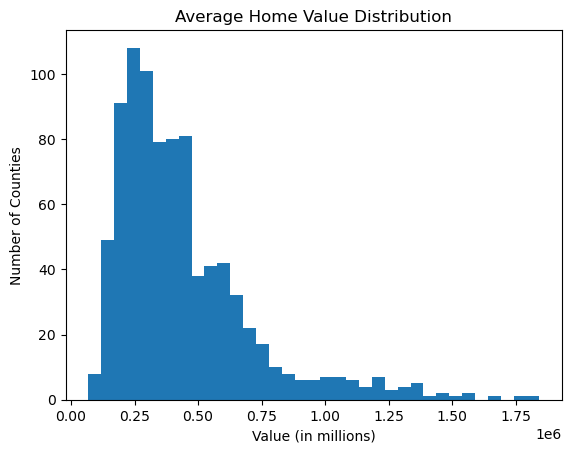

In [8]:
# VISUALIZE DISTRIBUTION OF HOME VALUE
plt.hist(df_latest['average_home_value'], bins = 35)
plt.title("Average Home Value Distribution")
plt.xlabel("Value (in millions)")
plt.ylabel("Number of Counties")


In [9]:
# AND GET A BASELINE IDEA OF VACANCY FOR COMPARISON WITH CANDIDATES
df_latest['vacancy_rate'].mean()

0.07663215712259834

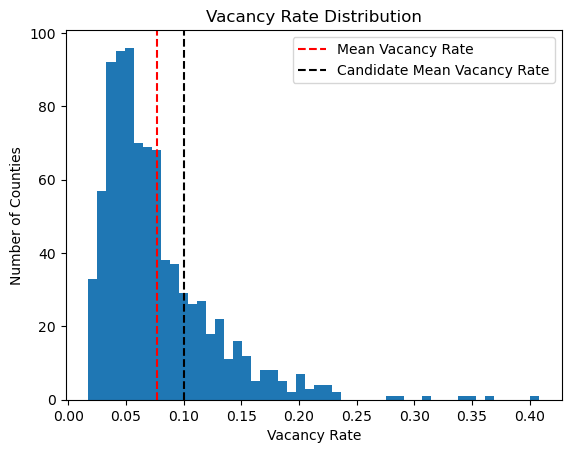

In [10]:
# VACANCY DISTRIBUTION
plt.hist(df_latest['vacancy_rate'], bins = 50)
plt.axvline(df_latest['vacancy_rate'].mean(), color = 'r', linestyle = 'dashed', label = 'Mean Vacancy Rate')
plt.axvline(df_latest_candidates['vacancy_rate'].mean(), color = 'k', linestyle = 'dashed', label = 'Candidate Mean Vacancy Rate')
plt.legend()
plt.title("Vacancy Rate Distribution")
plt.xlabel("Vacancy Rate")
plt.ylabel("Number of Counties")


NOTE THAT CANDIDATES HAVE A HIGHER VACANCY RATE ON AVERAGE; THIS MAYBE SHOULDN'T BE SHOCKING SINCE THEY ARE DECLINING FOR THREE YEARS STEADY - ONES THAT WERE ALREADY LOW HAD LESS ROOM FOR A DECREASE

In [11]:
print('mean current vacancy rate: ', df_latest['vacancy_rate'].mean())
print('median current vacancy rate: ', df_latest['vacancy_rate'].median())
print('25th percentile current vacancy rate: ', np.percentile(df_latest['vacancy_rate'], 25))


mean current vacancy rate:  0.07663215712259834
median current vacancy rate:  0.0636527002742835
25th percentile current vacancy rate:  0.043996775807165406


(array([ 8., 21., 27., 23., 40., 45., 35., 52., 47., 42., 42., 38., 23.,
        38., 29., 29., 30., 21., 18., 18., 20., 14., 16., 11., 11., 12.,
         9., 17., 10.,  7., 13.,  7.,  5.,  7.,  5.,  7.,  9.,  8.,  2.,
         1.,  2.,  5.,  4.,  2.,  6.,  2.,  3.,  1.,  2.,  3.]),
 array([0.01745517, 0.02106083, 0.0246665 , 0.02827217, 0.03187783,
        0.0354835 , 0.03908917, 0.04269483, 0.0463005 , 0.04990616,
        0.05351183, 0.0571175 , 0.06072316, 0.06432883, 0.0679345 ,
        0.07154016, 0.07514583, 0.0787515 , 0.08235716, 0.08596283,
        0.0895685 , 0.09317416, 0.09677983, 0.10038549, 0.10399116,
        0.10759683, 0.11120249, 0.11480816, 0.11841383, 0.12201949,
        0.12562516, 0.12923083, 0.13283649, 0.13644216, 0.14004782,
        0.14365349, 0.14725916, 0.15086482, 0.15447049, 0.15807616,
        0.16168182, 0.16528749, 0.16889316, 0.17249882, 0.17610449,
        0.17971016, 0.18331582, 0.18692149, 0.19052715, 0.19413282,
        0.19773849]),
 <BarContainer

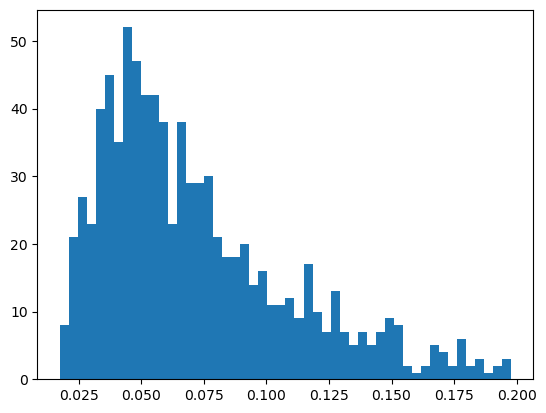

In [12]:
# A CLOSER LOOK AT DISTRIBUTION WITHOUT SOME OF THE OUTLIERS
plt.hist(df_latest[df_latest['vacancy_rate'] < 0.2]['vacancy_rate'], bins = 50)

In [13]:
df_orig = df.copy()

In [14]:
# MAKE VALI DATA SECOND TO LAST YEAR; TEST DATA LAST YEAR; TRAIN FIRST 6
last_year = df['year'].max()
train = df[df['year'] < last_year - 4]
vali = df[df['year'] == last_year - 1]
test = df[df['year'] == last_year]

In [15]:
print('training sample - ', len(train))
print('validation sample - ', len(vali))
print('test sample - ', len(test))

training sample -  4663
validation sample -  836
test sample -  840


In [16]:
for yr in set(df['year'].values.tolist()):
    print(yr, len(df[df['year'] == yr]))

2016 820
2017 826
2018 836
2019 840
2009 750
2010 765
2011 770
2012 785
2013 791
2014 802
2015 815


In [17]:
# SIZE OF DATASET WITH KNOWN ROI, WITH UNKNOWN ROI
print(len(df))
print(len(df_latest))

8800
871


In [18]:
# TESTING HAS SHOWN FAKE PREDS BEATS MODEL - WANNA SEE WHAT HAPPENS IF FAKE PRED IS A FEATURE
train['fake_pred'] = round(((train['average_home_value'] * (1 + train['home_val_growth_last_3_years']) - train['average_home_value']) + \
                     (
                        train['average_annual_rent'] * (1 + train['rent_growth_last_1_years']) +\
                        train['average_annual_rent'] * (1 + train['rent_growth_last_2_years']) +\
                        train['average_annual_rent'] * (1 + train['rent_growth_last_3_years'])
                     ))/train['average_home_value'], 4)

/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_92893/2596095845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['fake_pred'] = round(((train['average_home_value'] * (1 + train['home_val_growth_last_3_years']) - train['average_home_value']) + \


In [19]:
vali['fake_pred'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \
                     (
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_1_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_2_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_3_years'])
                     ))/vali['average_home_value'], 4)

/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_92893/1132831924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali['fake_pred'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \


In [20]:
#X, Y SPLITS
std_scl = StandardScaler()

ex_train = train.drop(columns = ['year', 'place', 'roi'])
ex_train_scaled = std_scl.fit_transform(ex_train)
why_train = train['roi']


ex_vali = vali.drop(columns = ['year', 'place', 'roi'])
ex_vali_scaled = std_scl.fit_transform(ex_vali)
why_vali = vali['roi']

ex_test = test.drop(columns = ['year', 'place', 'roi'])
ex_test_scaled = std_scl.fit_transform(ex_test)
why_test = test['roi']

In [21]:
mse = metrics.mean_squared_error
mae = metrics.mean_absolute_error

In [22]:
print('actuals mean - ', why_vali.mean())
print('actuals standard dev - ', why_vali.std())

actuals mean -  0.3233958133971292
actuals standard dev -  0.09878526930445224


In [23]:
print('rmse - ', m.sqrt(mse(why_vali, vali['fake_pred'])))
print('mae - ', mae(why_vali, vali['fake_pred']))
vali = vali.drop(columns = ['fake_pred'])

rmse -  0.08366455757236696
mae -  0.06512547846889953


QUICK NOTE THAT I USED TO INCLUDE LOGISTIC REGRESSION; RESULTS WERE POOR TO THE POINT OF NOT BEING WORTH FURTHER EXPLORATION

In [24]:
# LOOK AT OUT OF BOX RANDOM FOREST PERFORMANCE
rf = ens.RandomForestRegressor(random_state=123)

# TRAIN/VALI
rf_fit = rf.fit(ex_train, why_train)
rf_preds = rf_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, rf_preds)))
print('mae - ', mae(why_vali, rf_preds))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
rf_train_preds = rf.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, rf_train_preds)))
print('training mae - ', mae(why_train, rf_train_preds))

rmse -  0.2075529524331766
mae -  0.17872058732057416
training rmse -  0.024021978017758988
training mae -  0.01725818207162771


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_92893/3272181699.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = rf_df['feature_importance'], y = rf_df['feature_names'], ci = None)


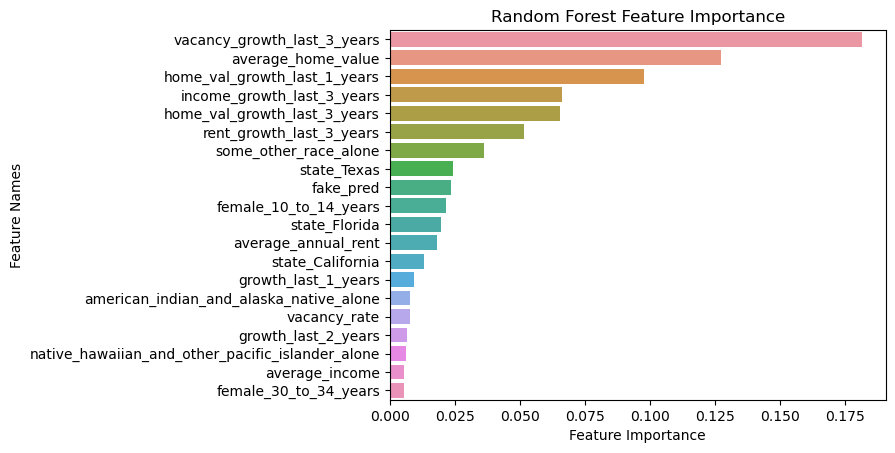

In [25]:
# PLOT MOST IMPORTANT FEATURES
feature_names = ex_train.columns
importances = rf_fit.feature_importances_
data = {'feature_names': feature_names, 'feature_importance': importances}
rf_df = pd.DataFrame(data)
rf_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
rf_df = rf_df.head(20)

sns.barplot(x = rf_df['feature_importance'], y = rf_df['feature_names'], ci = None)

#ADD CHART LABELS
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')


In [ ]:
# CHECK TUNED RF PERFORMANCE

In [26]:
%store -r rf_params

In [27]:
rf_params

{'n_estimators': 100, 'max_depth': 25, 'criterion': 'friedman_mse'}

In [28]:
# SET THIS (AND OTHER MODELS) UP TO BE ABLE TO HANDLE PCA OR NO
if sum([1 if 'pca__' in x else 0 for x in rf_params]) > 0:
    steps = [('pca', PCA(n_components = rf_params['pca__n_components'])), 
             ('rf', ens.RandomForestRegressor(n_estimators = rf_params['rf__n_estimators'], 
                                          max_depth = rf_params['rf__max_depth'],
                                          criterion = rf_params['rf__criterion']))]
    model_rf = Pipeline(steps = steps)

    
    
else:
    
    model_rf = ens.RandomForestRegressor(n_estimators = rf_params['n_estimators'], 
                                          max_depth = rf_params['max_depth'],
                                          criterion = rf_params['criterion'])
    
# TRAIN/VALI
rf_fit = model_rf.fit(ex_train, why_train)
rf_preds_tuned = rf_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, rf_preds_tuned)))
print('mae - ', mae(why_vali, rf_preds_tuned))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
rf_train_preds_tuned = model_rf.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, rf_train_preds_tuned)))
print('training mae - ', mae(why_train, rf_train_preds_tuned))

rmse -  0.20590211793988109
mae -  0.17710955713205973
training rmse -  0.024319201771647193
training mae -  0.017514656237669422


In [ ]:
# TUNED ADABOOST

In [29]:
%store -r ada_params

In [30]:
ada_params

{'n_estimators': 50, 'learning_rate': 0.1}

In [31]:
if sum([1 if 'pca__' in x else 0 for x in ada_params]) > 0:
    steps = [('pca', PCA(n_components = ada_params['pca__n_components'])), 
             ('ada', ens.AdaBoostRegressor(n_estimators = ada_params['ada__n_estimators'], 
                                           learning_rate = ada_params['ada__learning_rate']))]
             
    ada = Pipeline(steps = steps)
    
else:
    ada = ens.AdaBoostRegressor(n_estimators = ada_params['n_estimators'], 
                                learning_rate = ada_params['learning_rate'])

    
    
# TRAIN/VALI
ada_fit = ada.fit(ex_train, why_train)
ada_preds = ada_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, ada_preds)))
print('mae - ', mae(why_vali, ada_preds))
               
# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
ada_train_preds = ada.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, ada_train_preds)))
print('training mae - ', mae(why_train, ada_train_preds))

rmse -  0.1861287689654908
mae -  0.15897649163033578
training rmse -  0.1020260987174674
training mae -  0.07942574691183575


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_92893/3599529484.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)


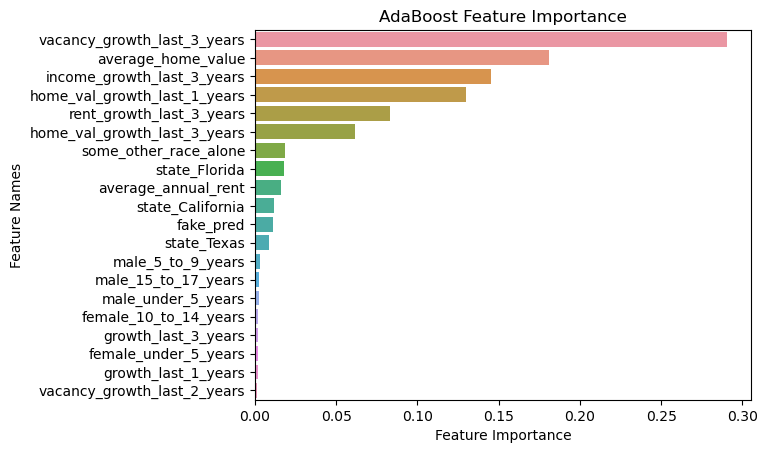

In [32]:
if sum([1 if 'pca__' in x else 0 for x in ada_params]) == 0:
    feature_names = ex_train.columns
    importances = ada_fit.feature_importances_
    data = {'feature_names': feature_names, 'feature_importance': importances}
    ada_df = pd.DataFrame(data)
    ada_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    ada_df = ada_df.head(20)

    sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)

    #ADD CHART LABELS
    plt.title('AdaBoost Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    

In [ ]:
# TUNED XGBOOST

In [33]:
%store -r xgboost_params

In [34]:
xgboost_params

{'scale_pos_weight': 1, 'max_depth': 7, 'eta': 0.30000000000000004}

In [35]:
# XGBOOST IS BEING A CRYBABY ABOUT TYPES IDK WHY, BUT WHATEVER I'LL EXPLICITLY FIX LOL
ex_train['average_annual_rent'] = ex_train['average_annual_rent'].astype(float)
ex_train['average_home_value'] = ex_train['average_home_value'].astype(float)
ex_train['average_income'] = ex_train['average_income'].astype(float)

ex_vali['average_annual_rent'] = ex_vali['average_annual_rent'].astype(float)
ex_vali['average_home_value'] = ex_vali['average_home_value'].astype(float)
ex_vali['average_income'] = ex_vali['average_income'].astype(float)



if sum([1 if 'pca__' in x else 0 for x in xgboost_params]) > 0:
    steps = [('pca', PCA(n_components = xgboost_params['pca__n_components'])), 
             ('xg', XGBRegressor(scale_pos_weight = xgboost_params['xg__scale_pos_weight'],
                                  max_depth = xgboost_params['xg__max_depth'], 
                                  eta = xgboost_params['xg__eta']))]
             
    xg = Pipeline(steps = steps)
    
else:
    xg = XGBRegressor(scale_pos_weight = xgboost_params['scale_pos_weight'],
                  max_depth = xgboost_params['max_depth'], 
                  eta = xgboost_params['eta'])

# TRAIN/VALI
xg_fit = xg.fit(ex_train, why_train)
xg_preds = xg_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, xg_preds)))
print('mae - ', mae(why_vali, xg_preds))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
xg_train_preds = xg.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, xg_train_preds)))
print('training mae - ', mae(why_train, xg_train_preds))

rmse -  0.19505132633896538
mae -  0.16317441693056803
training rmse -  0.005440938337581118
training mae -  0.003944518385375366


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_92893/3296612298.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)


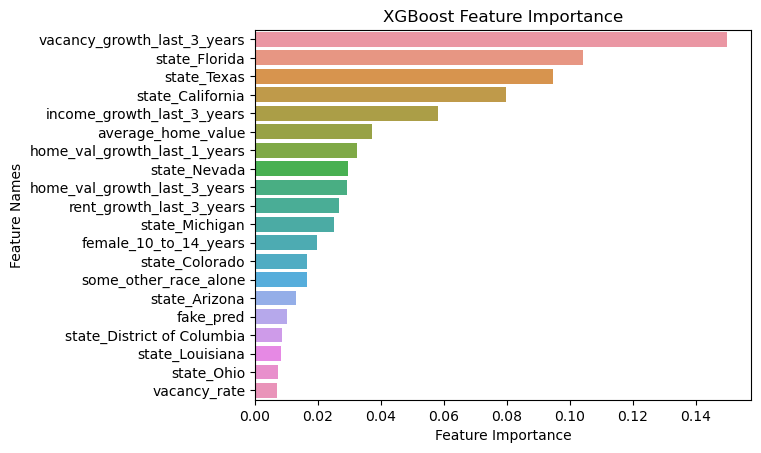

In [36]:
if sum([1 if 'pca__' in x else 0 for x in xgboost_params]) == 0:
    feature_names = ex_train.columns
    importances = xg_fit.feature_importances_
    data = {'feature_names': feature_names, 'feature_importance': importances}
    xg_df = pd.DataFrame(data)
    xg_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    xg_df = xg_df.head(20)

    sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)

    #ADD CHART LABELS
    plt.title('XGBoost Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    

In [37]:
# SO HEURISTIC MODEL IS ACUTALLY BEST => BASE PREDS ON THIS AND CHECK ITS VALIDATION PERFORMANCE

vali['predicted_roi'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \
                     (
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_1_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_2_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_3_years'])
                     ))/vali['average_home_value'], 4)

In [38]:
# SORT VALIDATION BY PREDICTED ROI AND DROP COLUMNS UNNECESSARY FOR LATER CHECKS
pred_check = vali.sort_values(by = 'predicted_roi', ascending = False)
pred_check = pred_check.drop(columns = [x for x in df.columns if x != 'place' and\
                                        x != 'year' and x != 'average_annual_rent' and\
                                        x != 'average_home_value' and x != 'total_population' and\
                                        'roi' not in x])


In [39]:
# PULL ERRORS
df_ec = vali.copy()
df_ec['error'] = round(df_ec['predicted_roi'] - df_ec['roi'], 3)

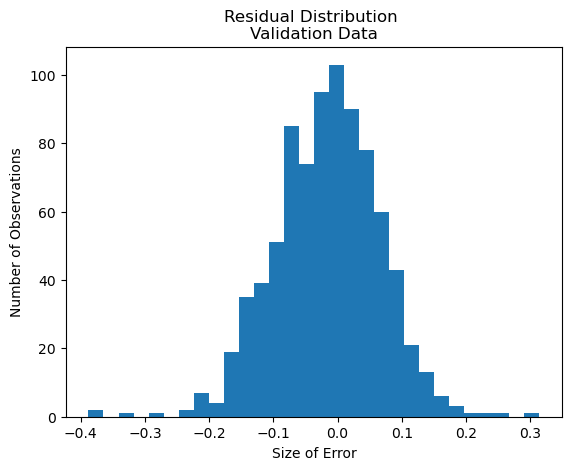

In [40]:
# AND VISUALIZE DISTRIBUTION
plt.hist(df_ec['error'], bins = 30)
plt.title("Residual Distribution \nValidation Data")
plt.xlabel("Size of Error")
plt.ylabel("Number of Observations")


CHECKING IN, NONE OF THE MODELS (OFF THE SHELF OR TUNED) ACTUALLY BEAT THE "DUMB" BASELINE SET WITH A SIMPLE LINEAR COMBINATION OF THE LAST THREE YEARS OF GROWTH PROJECTED TO THE NEXT THREE (FOR RENT AND HOME VALUE). 

HAVING SAID THAT, THE BASELINE MODEL ACTUALLY PERFORMS WELL, BEATING STANDARD DEVIATION OF THE VALIDATION SET'S ROI. THIS IMPLIES THAT IT DOES BETTER THAN PREDICTING THE SET'S AVERAGE (THIS IS HARDER THAN IT SOUNDS AS WE DON'T HAVE THE AVERAGE AHEAD OF TIME), SO THE "DUMB" MODEL ITSELF IS ACTUALLY A FAIRLY USEFUL TOOL. THIS IS SEEMINGLY CONFIRMED BY THE ERROR'S (SOMEWHAT) NORMAL DISTRIBUTION ABOUT 0.

NEXT, WE CHECK WITH A MORE "REAL WORLD" TEST. REALISTICALLY WE WOULD NOT BE BUYING AND SHORTING ON EVERY CITY'S REAL ESTATE MARKET, SO THE BETTER APPLICATION IS TO SEE WHAT WOULD HAVE HAPPENED IF WE HAD USED THE MODEL TO IDENTIFY TOP CANDIDATES IN THE LATEST YEAR OF TESTABLE DATA. I CONSIDER ANY CANDIDATE IDENTIFIED THAT WOULD HAVE PERFORMED BETTER THAN AVERAGE ACCEPTABLE (THRESHOLD IN CELL BELOW).

In [41]:
print(pred_check['roi'].mean())
print(pred_check['roi'].median())

0.3233958133971292
0.32120000000000004


In [42]:
pred_check.head(25)

,year,place,average_annual_rent,average_home_value,total_population,roi,predicted_roi
243090,2018,Homestead city - Florida,12805.44,205563.55,68424,0.4291,0.7427
243008,2018,Fountainebleau CDP - Florida,16295.28,212014.00,59833,0.4632,0.5992
243514,2018,Tamarac city - Florida,15071.64,178162.49,64748,0.5027,0.5839
241360,2018,Hemet city - California,11911.56,195330.78,84069,0.3378,0.5830
242253,2018,Commerce City city - Colorado,13604.04,298314.84,54795,0.4032,0.5799
241781,2018,Pittsburg city - California,17344.68,376490.16,70492,0.4145,0.5790
243184,2018,Lauderhill city - Florida,13437.12,162409.51,71328,0.6239,0.5521
243193,2018,Lehigh Acres CDP - Florida,10427.40,152609.59,119205,0.5387,0.5509
240025,2018,Avondale city - Arizona,11496.96,201756.90,83392,0.4560,0.5500
243149,2018,Kissimmee city - Florida,11376.24,179173.48,69833,0.4643,0.5486


NO WOULD-BE CANDIDATES FALL BELOW OUR THRESHOLD (MEAN OR MEDIAN ROI), SO WHILE THE MODEL ISN'T PERFECT IT WOULD HAVE IDENTIFIED QUALITY CANDIDATES FROM WHICH TO CHOOSE (AKA IT'S USEFUL). 

HAVING SAID THAT, IT CONSISTENTLY OVERESTIMATED THESE CANDIDATES' PERFORMANCE. I NEXT CHECK MEAN PREDICTED ROI VERSUS MEAN ROI TO SEE IF THIS IS A WIDESPREAD PROBLEM. IN ADDITION, I CHECK THE TOP ACTUAL PERFORMERS TO SEE HOW THE MODEL WOULD HAVE RATED THEM (IT'S MORE IMPORTANT THAT IT'S HIGH RATINGS AREN'T ACTUALLY BAD, BUT IDEALLY ACTUALLY GOOD PERFORMERS WOULD NOT BE RATED AS BAD EITHER). FINALLY, I CHECK TO SEE HOW MUCH OVERLAP THERE WOULD HAVE BEEN BETWEEN TOP CANDIDATES IDENTIFIED AND TOP PERFORMERS.

In [43]:
print('predicted - ', pred_check['predicted_roi'].mean())
print('actual - ', pred_check['roi'].mean())

predicted -  0.30709425837320575
actual -  0.3233958133971292


In [44]:
#PRETTY CLOSE!

In [45]:
pred_check.sort_values(by = 'roi', ascending = False).head(25)

,year,place,average_annual_rent,average_home_value,total_population,roi,predicted_roi
244395,2018,Caldwell city - Idaho,8265.60,142924.74,53205,0.8646,0.4764
243374,2018,Pine Hills CDP - Florida,10138.20,130756.86,75575,0.7808,0.5078
244502,2018,Nampa city - Idaho,8836.44,163784.54,91663,0.6862,0.4727
249869,2018,Flint city - Michigan,5908.32,47133.92,97161,0.6543,0.3169
243184,2018,Lauderhill city - Florida,13437.12,162409.51,71328,0.6239,0.5521
243246,2018,Miami Gardens city - Florida,12626.88,189457.86,112913,0.6142,0.5219
244490,2018,Meridian city - Idaho,11963.64,258787.66,97008,0.5873,0.3556
255127,2018,Utica city - New York,7521.00,117217.11,60675,0.5846,0.2108
243508,2018,Sunrise city - Florida,16504.92,188047.93,93199,0.5770,0.5208
249821,2018,Detroit city - Michigan,7401.36,75133.92,677155,0.5691,0.5181


In [46]:
[place for place in pred_check.head(25)['place'].values.tolist() if \
 place in pred_check.sort_values(by = 'roi', ascending = False).head(25)['place'].values.tolist()]

['Lauderhill city - Florida',
 'Lehigh Acres CDP - Florida',
 'Miami Gardens city - Florida',
 'Sunrise city - Florida',
 'Detroit city - Michigan']

SO, 2 OF THE TOP PERFORMERS HAD A BELOW AVERAGE PREDICTION, AND 5 CITIES WOULD HAVE BEEN TOP 25 IN BOTH PREDICTED AND ACTUAL ROI. GIVEN THAT THE TOP PREDICTED ALL WERE ABOVE AVERAGE, I'D CONCLUDE THAT WHILE THERE IS DEFINITELY ROOM FOR IMPROVEMENT, THE REAL ESTATE INVESTMENT MODEL WOULD HAVE DONE MEANINGFULLY BETTER THAN RANDOM.

PUT ANOTHER WAY, WHILE I WOULD NOT RECOMMEND USING IT BLINDLY TO PICK A CITY FOR INVESTMENT, IT'S A USEFUL TOOL FOR NARROWING DOWN THE POOL OF CANDIDATES. WHILE YOU MAY MISS OUT ON THE TOP POSSIBLE INVESTMENT OPPORTUNITY, IT'S PREVIOUS PERFORMANCE SUGGESTS YOU'D BE LIKELY TO HAVE A SOLID PICK.

FOR NEXT IMMEDIATE STEPS, I MAKE THE DATA AVAILABLE IN AN API. LONG-TERM, FURTHER RESEARCH ON A MACHINE-LEARNING-ENGINEERED SOLUTION TO BEAT OUR HEURISTIC WOULD BE GOOD (E.G. TESTING DIFFERENT PCA KERNELS, DEEP LEARNING METHODS, ETC.), BUT IMPROVED DATA WOULD LIKELY BE KEY AS WELL.

In [47]:
df_latest = df_latest.dropna()
df_latest = df_latest.drop(columns = [x for x in df_latest.columns if 'state_' in x])

In [48]:
df_latest['pred'] = round(((df_latest['average_home_value'] * (1 + df_latest['home_val_growth_last_3_years']) - df_latest['average_home_value']) + \
                     (
                        df_latest['average_annual_rent'] * (1 + df_latest['rent_growth_last_1_years']) +\
                        df_latest['average_annual_rent'] * (1 + df_latest['rent_growth_last_2_years']) +\
                        df_latest['average_annual_rent'] * (1 + df_latest['rent_growth_last_3_years'])
                     ))/df_latest['average_home_value'], 4)

In [49]:
# MAKE PLACE EASIER FOR API I.E. NO SPACES; WANNA KEEP IN ORIGINAL DF IN CASE I WANT FURTHER ANALYSIS
df_save = df_latest.copy()
df_save['place'] = df_save['place'].apply(lambda x: re.sub(' ', '.', 
                                                           re.sub('St.', 'Saint', 
                                                                  re.sub(' - ', '.', x))))

In [50]:
df_save.to_csv("latest_yrs_w_preds_city.csv", index = False)